# Data Understanding & Visualization

- 데이터 확인
- 시간에 따라 어떻게 값이 변하는지 Graph (Lineplot) check
- Missing_value, Outlier Check

## 핵심 변수
1. activePower (kW) : 순간 소비 전력 확인
2. localtime (한국 시간대) : 시간대별 사용 패턴 분석
3. accumActiveEnergy (kWh) : 누적 소비량 확인
4. operation (1 = 가동) : 가동 여부에 따라 소비량 유무 결정
5. voltage / current : 급변 시 이상 탐지, 부하 변화 감지

In [54]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf, grangercausalitytests
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor


plt.rcParams['font.family'] = 'AppleGothic'  # Mac
plt.rcParams['axes.unicode_minus'] = False
sns.set(font='AppleGothic')

In [4]:
train_path = "/Users/b._.chan/Documents/DKU_DataScience/Not_Null/data/raw/train.csv"
test_path = "/Users/b._.chan/Documents/DKU_DataScience/Not_Null/data/raw/test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df.head()

,module(equipment),timestamp,localtime,operation,voltageR,voltageS,voltageT,voltageRS,voltageST,voltageTR,currentR,currentS,currentT,activePower,powerFactorR,powerFactorS,powerFactorT,reactivePowerLagging,accumActiveEnergy
0,14(2호기),1739918155000,20250218143555,1,216.65,215.21,216.89,373.99,374.20,375.45,17.76,6.59,10.99,2039.66,91.24,93.67,88.05,369.96,8789565
1,16(호이스트),1742552385000,20250321031945,1,212.13,216.51,218.88,371.20,377.04,373.26,17.75,12.07,10.94,2339.27,94.75,88.46,93.38,423.29,9147762
2,11(우측분전반1),1738245780000,20250130060300,1,219.30,211.36,212.71,372.96,367.24,374.12,27.54,12.88,24.68,3736.34,98.70,87.36,88.44,490.54,5480746
3,5(좌측분전반),1740645790000,20250227004310,1,214.15,213.73,210.73,370.54,367.58,367.95,26.78,7.03,22.33,3185.26,98.62,90.41,92.84,466.56,9190918
4,18(우측분전반2),1737829500000,20250125102500,1,212.07,215.52,215.66,370.29,373.40,370.41,29.51,8.88,6.82,2571.53,85.52,90.74,97.44,392.70,8606780


In [5]:
# localtime column 확인
train_df["localtime"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 23587209 entries, 0 to 23587208
Series name: localtime
Non-Null Count     Dtype
--------------     -----
23587209 non-null  int64
dtypes: int64(1)
memory usage: 180.0 MB


In [6]:
train_df["timestamp"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 23587209 entries, 0 to 23587208
Series name: timestamp
Non-Null Count     Dtype
--------------     -----
23587209 non-null  int64
dtypes: int64(1)
memory usage: 180.0 MB


In [7]:
train_df.shape

(23587209, 19)

In [8]:
train_df.describe()

,timestamp,localtime,operation,voltageR,voltageS,voltageT,voltageRS,voltageST,voltageTR,currentR,currentS,currentT,activePower,powerFactorR,powerFactorS,powerFactorT,reactivePowerLagging,accumActiveEnergy
count,2.358721e+07,2.358721e+07,23587209.0,2.358721e+07,2.358721e+07,2.358721e+07,2.358721e+07,2.358721e+07,2.358721e+07,2.358721e+07,2.358721e+07,2.358721e+07,2.358721e+07,2.358721e+07,2.358721e+07,2.358721e+07,2.358721e+07,2.358721e+07
mean,1.739519e+12,2.024839e+13,1.0,2.149942e+02,2.149946e+02,2.149940e+02,3.723703e+02,3.723701e+02,3.723697e+02,1.750025e+01,1.749881e+01,1.750207e+01,3.009983e+03,9.246880e+01,9.247010e+01,9.246983e+01,6.019165e+02,8.104020e+06
std,3.739740e+09,3.664714e+09,0.0,2.901942e+00,2.902580e+00,2.902125e+00,3.572992e+00,3.572323e+00,3.572550e+00,7.217243e+00,7.217451e+00,7.217173e+00,7.172040e+02,4.405030e+00,4.405401e+00,4.405663e+00,2.290891e+02,3.344687e+06
min,1.733040e+12,2.024120e+13,1.0,1.901000e+02,1.901400e+02,1.901900e+02,3.308300e+02,3.312700e+02,3.305600e+02,5.000000e+00,5.000000e+00,5.000000e+00,8.644400e+02,6.000000e+01,6.000000e+01,6.000000e+01,8.944000e+01,1.129013e+06
25%,1.736280e+12,2.025011e+13,1.0,2.125000e+02,2.125000e+02,2.125000e+02,3.698400e+02,3.698400e+02,3.698400e+02,1.125000e+01,1.125000e+01,1.125000e+01,2.503740e+03,8.873000e+01,8.873000e+01,8.873000e+01,4.231400e+02,5.394751e+06
50%,1.739521e+12,2.025021e+13,1.0,2.150000e+02,2.150000e+02,2.150000e+02,3.723800e+02,3.723800e+02,3.723800e+02,1.750000e+01,1.750000e+01,1.750000e+01,3.009880e+03,9.249000e+01,9.249000e+01,9.249000e+01,5.739000e+02,8.104245e+06
75%,1.742757e+12,2.025032e+13,1.0,2.175000e+02,2.175000e+02,2.175000e+02,3.749200e+02,3.749100e+02,3.749200e+02,2.375000e+01,2.375000e+01,2.375000e+01,3.515950e+03,9.624000e+01,9.625000e+01,9.624000e+01,7.553800e+02,1.081312e+07
max,1.745996e+12,2.025043e+13,1.0,2.200000e+02,2.200000e+02,2.200000e+02,3.810400e+02,3.810400e+02,3.810400e+02,3.000000e+01,3.000000e+01,3.000000e+01,5.219730e+03,1.000000e+02,1.000000e+02,1.000000e+02,1.550630e+03,1.543817e+07


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23587209 entries, 0 to 23587208
Data columns (total 19 columns):
 #   Column                Dtype  
---  ------                -----  
 0   module(equipment)     object 
 1   timestamp             int64  
 2   localtime             int64  
 3   operation             int64  
 4   voltageR              float64
 5   voltageS              float64
 6   voltageT              float64
 7   voltageRS             float64
 8   voltageST             float64
 9   voltageTR             float64
 10  currentR              float64
 11  currentS              float64
 12  currentT              float64
 13  activePower           float64
 14  powerFactorR          float64
 15  powerFactorS          float64
 16  powerFactorT          float64
 17  reactivePowerLagging  float64
 18  accumActiveEnergy     int64  
dtypes: float64(14), int64(4), object(1)
memory usage: 3.3+ GB


In [10]:
train_df["localtime"] = pd.to_datetime(train_df["localtime"], format="%Y%m%d%H%M%S")

In [11]:
train_df["localtime"].head()

0   2025-02-18 14:35:55
1   2025-03-21 03:19:45
2   2025-01-30 06:03:00
3   2025-02-27 00:43:10
4   2025-01-25 10:25:00
Name: localtime, dtype: datetime64[ns]

In [12]:
train_df.head()

,module(equipment),timestamp,localtime,operation,voltageR,voltageS,voltageT,voltageRS,voltageST,voltageTR,currentR,currentS,currentT,activePower,powerFactorR,powerFactorS,powerFactorT,reactivePowerLagging,accumActiveEnergy
0,14(2호기),1739918155000,2025-02-18 14:35:55,1,216.65,215.21,216.89,373.99,374.20,375.45,17.76,6.59,10.99,2039.66,91.24,93.67,88.05,369.96,8789565
1,16(호이스트),1742552385000,2025-03-21 03:19:45,1,212.13,216.51,218.88,371.20,377.04,373.26,17.75,12.07,10.94,2339.27,94.75,88.46,93.38,423.29,9147762
2,11(우측분전반1),1738245780000,2025-01-30 06:03:00,1,219.30,211.36,212.71,372.96,367.24,374.12,27.54,12.88,24.68,3736.34,98.70,87.36,88.44,490.54,5480746
3,5(좌측분전반),1740645790000,2025-02-27 00:43:10,1,214.15,213.73,210.73,370.54,367.58,367.95,26.78,7.03,22.33,3185.26,98.62,90.41,92.84,466.56,9190918
4,18(우측분전반2),1737829500000,2025-01-25 10:25:00,1,212.07,215.52,215.66,370.29,373.40,370.41,29.51,8.88,6.82,2571.53,85.52,90.74,97.44,392.70,8606780


In [13]:
# localtime 을 축으로 진행
train_df = train_df.set_index("localtime").sort_index()

In [14]:
train_df.head()

,module(equipment),timestamp,operation,voltageR,voltageS,voltageT,voltageRS,voltageST,voltageTR,currentR,currentS,currentT,activePower,powerFactorR,powerFactorS,powerFactorT,reactivePowerLagging,accumActiveEnergy
localtime,,,,,,,,,,,,,,,,,,
2024-12-01,4(분쇄기(1)),1733040000000,1,219.48,219.71,216.77,380.34,377.99,377.79,10.71,16.57,19.60,2730.42,85.63,98.56,90.93,417.08,2462003
2024-12-01,1(PM-3),1733040000000,1,214.38,214.45,219.10,371.37,375.45,375.39,15.16,15.53,20.65,2961.61,87.31,99.71,89.45,785.37,1955004
2024-12-01,12(4호기),1733040000000,1,217.12,215.58,219.07,374.72,376.41,377.74,12.66,9.71,9.46,1843.92,97.16,92.48,97.09,539.70,4552002
2024-12-01,13(3호기),1733040000000,1,217.90,212.34,214.12,372.58,369.32,374.13,25.95,17.69,21.01,3709.16,96.90,88.27,92.41,749.55,2149005
2024-12-01,3(분쇄기(2)),1733040000000,1,217.52,212.16,214.54,372.10,369.53,374.17,25.99,5.25,24.22,3190.00,97.45,94.63,85.81,496.22,3678004


In [15]:
# 결측치 확인
train_df.isnull().sum()

module(equipment)       0
timestamp               0
operation               0
voltageR                0
voltageS                0
voltageT                0
voltageRS               0
voltageST               0
voltageTR               0
currentR                0
currentS                0
currentT                0
activePower             0
powerFactorR            0
powerFactorS            0
powerFactorT            0
reactivePowerLagging    0
accumActiveEnergy       0
dtype: int64

- 결측치는 없는 것으로 확인됨

In [46]:
if train_df.duplicated().any():
    display(train_df[train_df.duplicated(keep=False)].head())

In [16]:
train_df.duplicated().sum()

np.int64(0)

- 중복된 행도 없는 것으로 확인됨.

/Users/b._.chan/Documents/DKU_DataScience/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


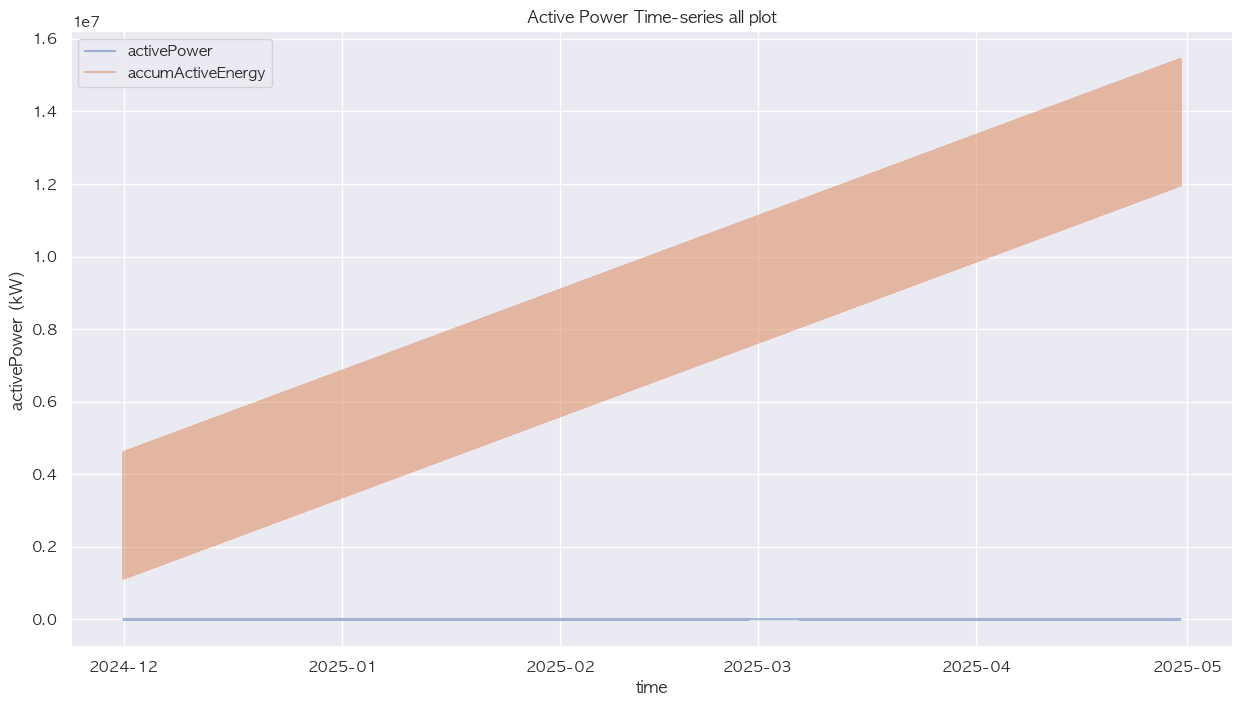

In [48]:
plt.figure(figsize=(15, 8))
plt.plot(train_df["activePower"], alpha = 0.5, label="activePower")
plt.plot(train_df["accumActiveEnergy"], alpha = 0.5, label="accumActiveEnergy")
plt.title("Active Power Time-series all plot")
plt.xlabel("time")
plt.ylabel("activePower (kW)")
plt.legend()
plt.show()

- 전체 추세와 이상치는 탐지되지 않음.

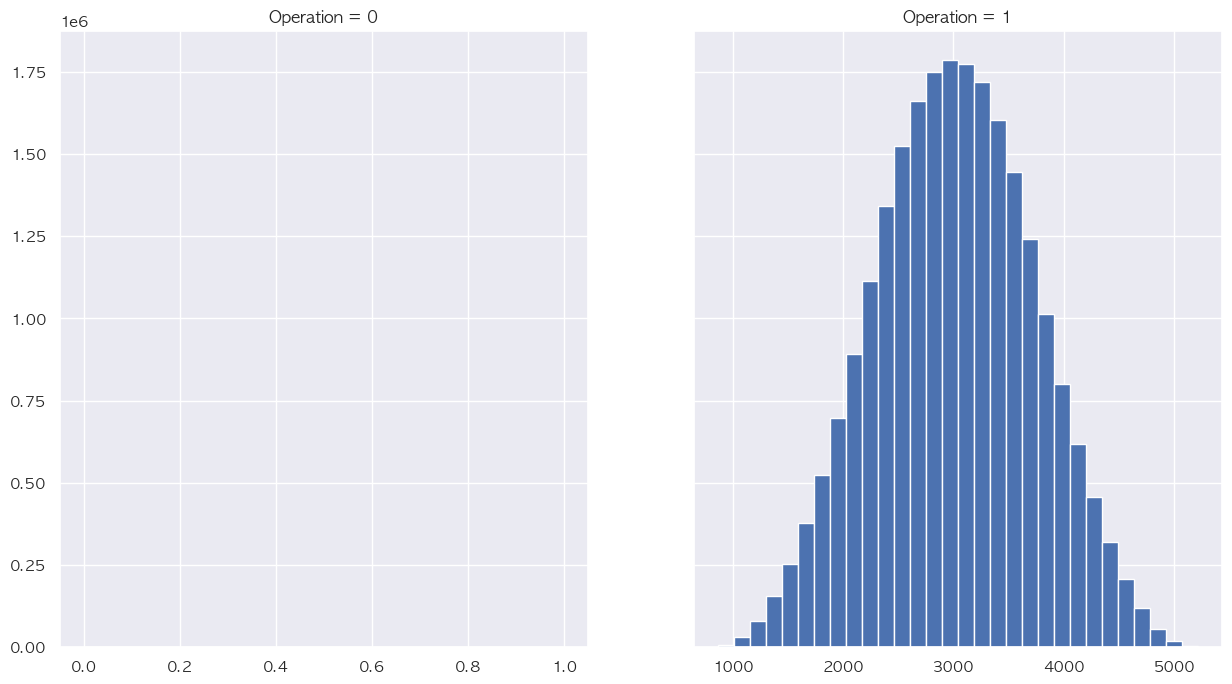

In [18]:
# operation column check
fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharey=True)
train_df[train_df["operation"] == 0]["activePower"].hist(ax=axes[0], bins=30)
axes[0].set_title("Operation = 0")
train_df[train_df["operation"] == 1]["activePower"].hist(ax=axes[1], bins=30)
axes[1].set_title("Operation = 1")
plt.show()



- operation (1은 작동 상태) 은 모든 설비가 작동 상태임을 확인할 수 있음.
- 심지어, 거의 완벽한 normal distribution 을 띄고 있음.

<Figure size 1500x800 with 0 Axes>

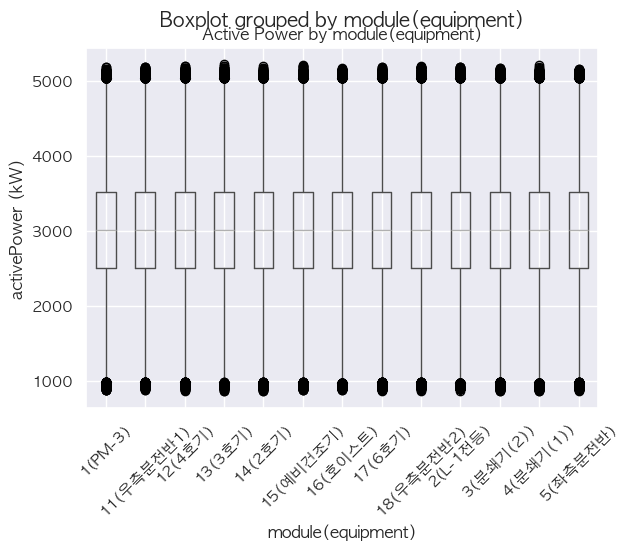

In [19]:
# module 별 boxplot check
plt.figure(figsize=(15, 8))
train_df.boxplot(column="activePower", by="module(equipment)")
plt.title("Active Power by module(equipment)")
plt.xlabel("module(equipment)")
plt.ylabel("activePower (kW)")
plt.xticks(rotation=45)
plt.show()

- 장비별로 확인해본 결과 특정 장치의 이상치는 발견되지 않음.

## 다변수 파악

- "activePower" 제외 나머지 핵심 변수들 파악하였음.
- 핵심 변수들 모아서 다시 파악.

In [20]:
main_hourly = train_df.resample("1h").agg({
    'activePower':      'sum',
    'accumActiveEnergy':'last',
    'operation': 'max',
    'voltageR': 'mean',
    'voltageS': 'mean',
    'voltageT': 'mean',
    'currentR': 'mean',
    'currentS': 'mean',
    'currentT': 'mean'
}).dropna()

main_hourly.head()

main_hourly.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3601 entries, 2024-12-01 00:00:00 to 2025-04-30 00:00:00
Freq: h
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   activePower        3601 non-null   float64
 1   accumActiveEnergy  3601 non-null   int64  
 2   operation          3601 non-null   int64  
 3   voltageR           3601 non-null   float64
 4   voltageS           3601 non-null   float64
 5   voltageT           3601 non-null   float64
 6   currentR           3601 non-null   float64
 7   currentS           3601 non-null   float64
 8   currentT           3601 non-null   float64
dtypes: float64(7), int64(2)
memory usage: 281.3 KB


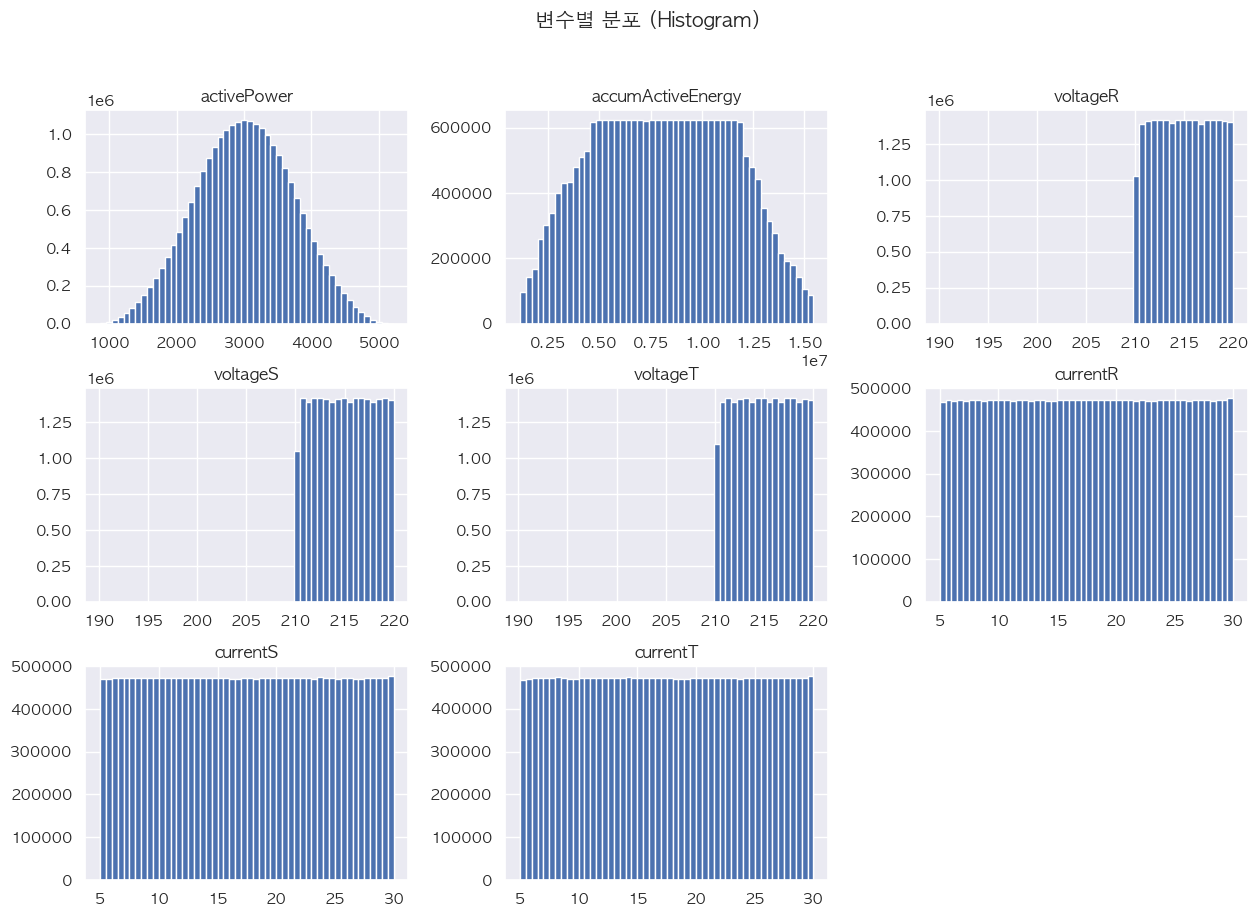

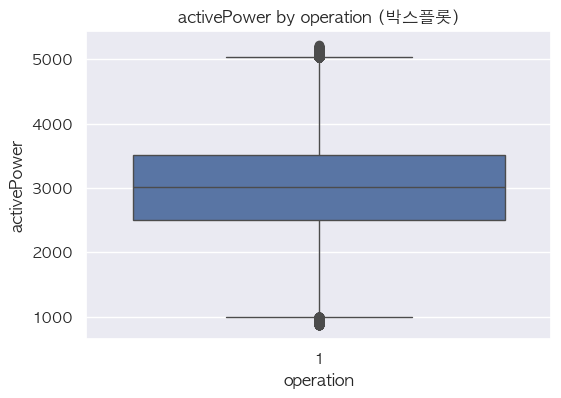

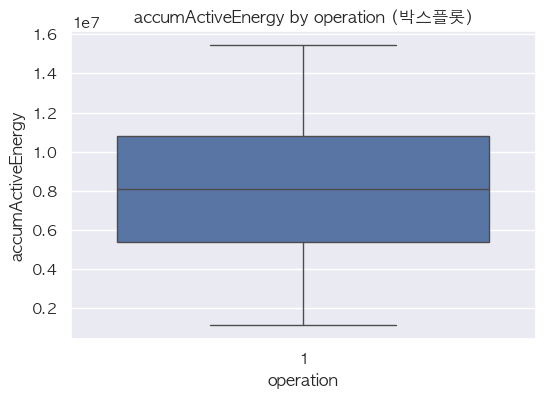

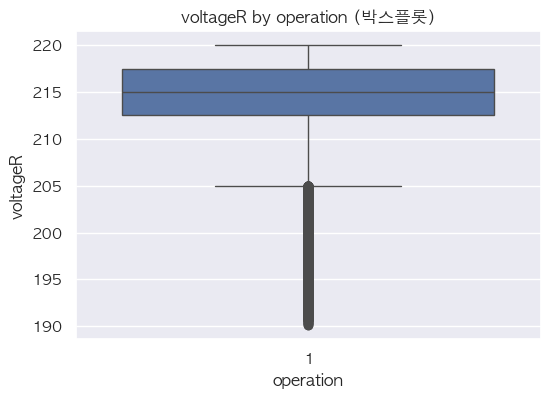

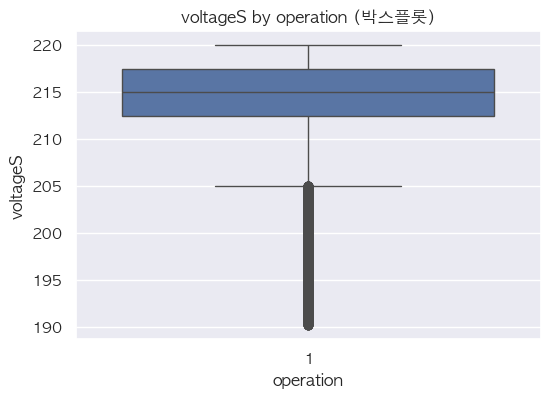

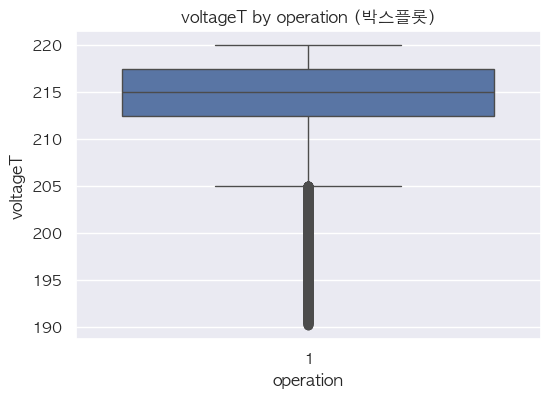

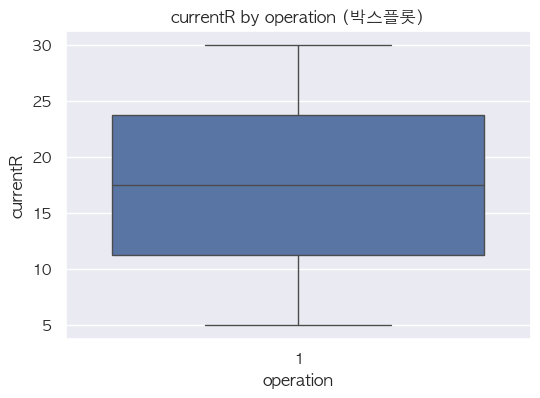

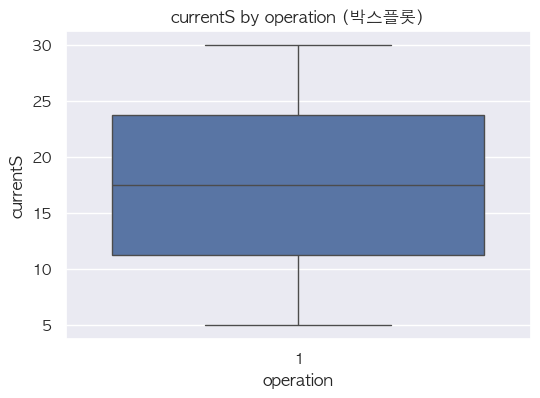

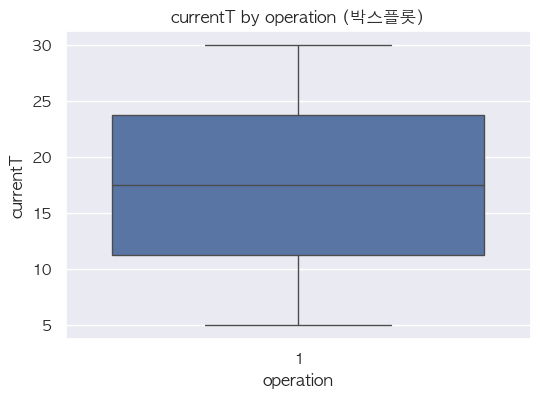

In [64]:
vars = ["activePower","accumActiveEnergy","voltageR","voltageS","voltageT","currentR","currentS","currentT"]
# 1-1) 히스토그램
train_df[vars].hist(bins=50, figsize=(15,10))
plt.suptitle("변수별 분포 (Histogram)")
plt.show()

# 1-2) 박스플롯 & 바이올린 (operation별 비교)
for v in vars:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="operation", y=v, data=train_df)
    plt.title(f"{v} by operation (박스플롯)")
    plt.show()

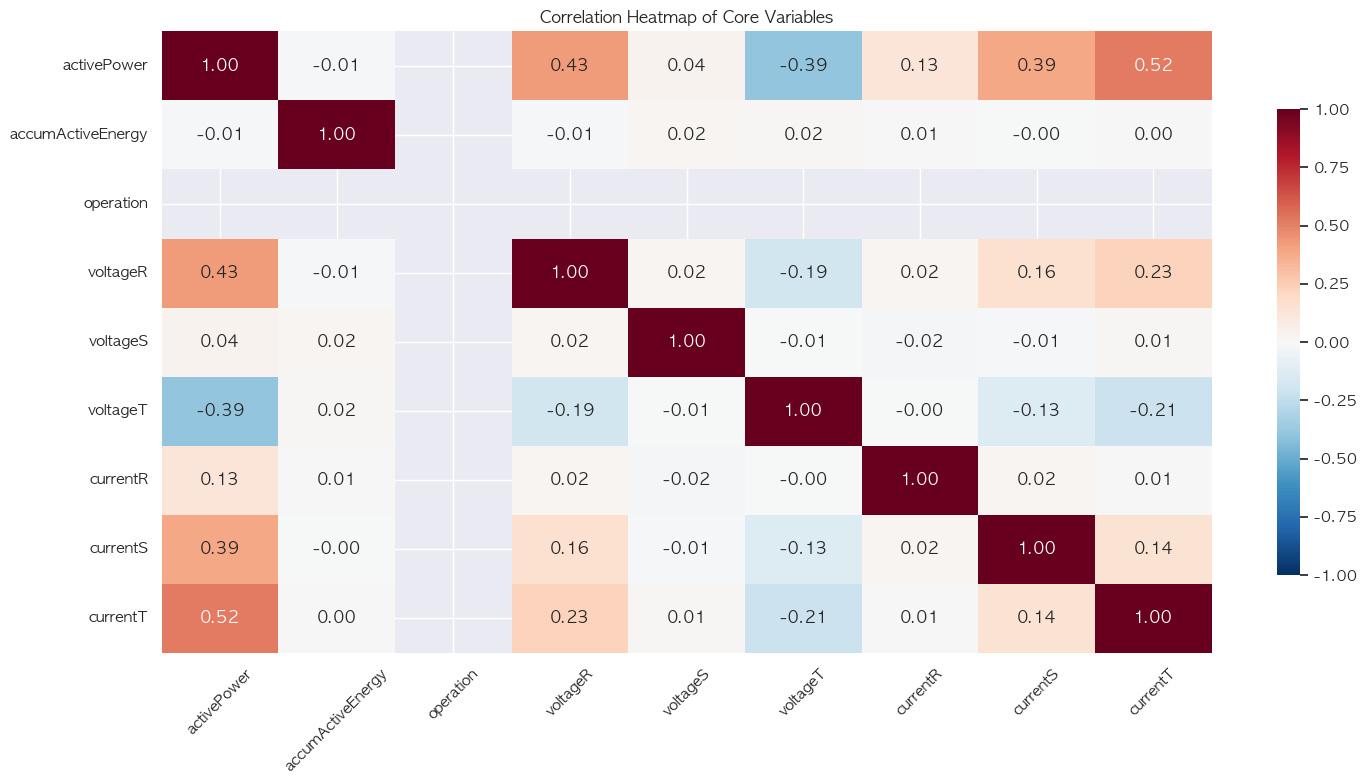

In [44]:
corr = main_hourly.corr()

plt.figure(figsize=(15, 8))
sns.heatmap(corr, annot=True, fmt=".2f",vmin=-1, vmax=1, cmap="RdBu_r", cbar_kws={"shrink": 0.75})
plt.title("Correlation Heatmap of Core Variables")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

< 다중공선성 파악 >
- 

- 다중공선성을 우려할만한 주요 핵심 변수들 중에서는 존재하지 않음.

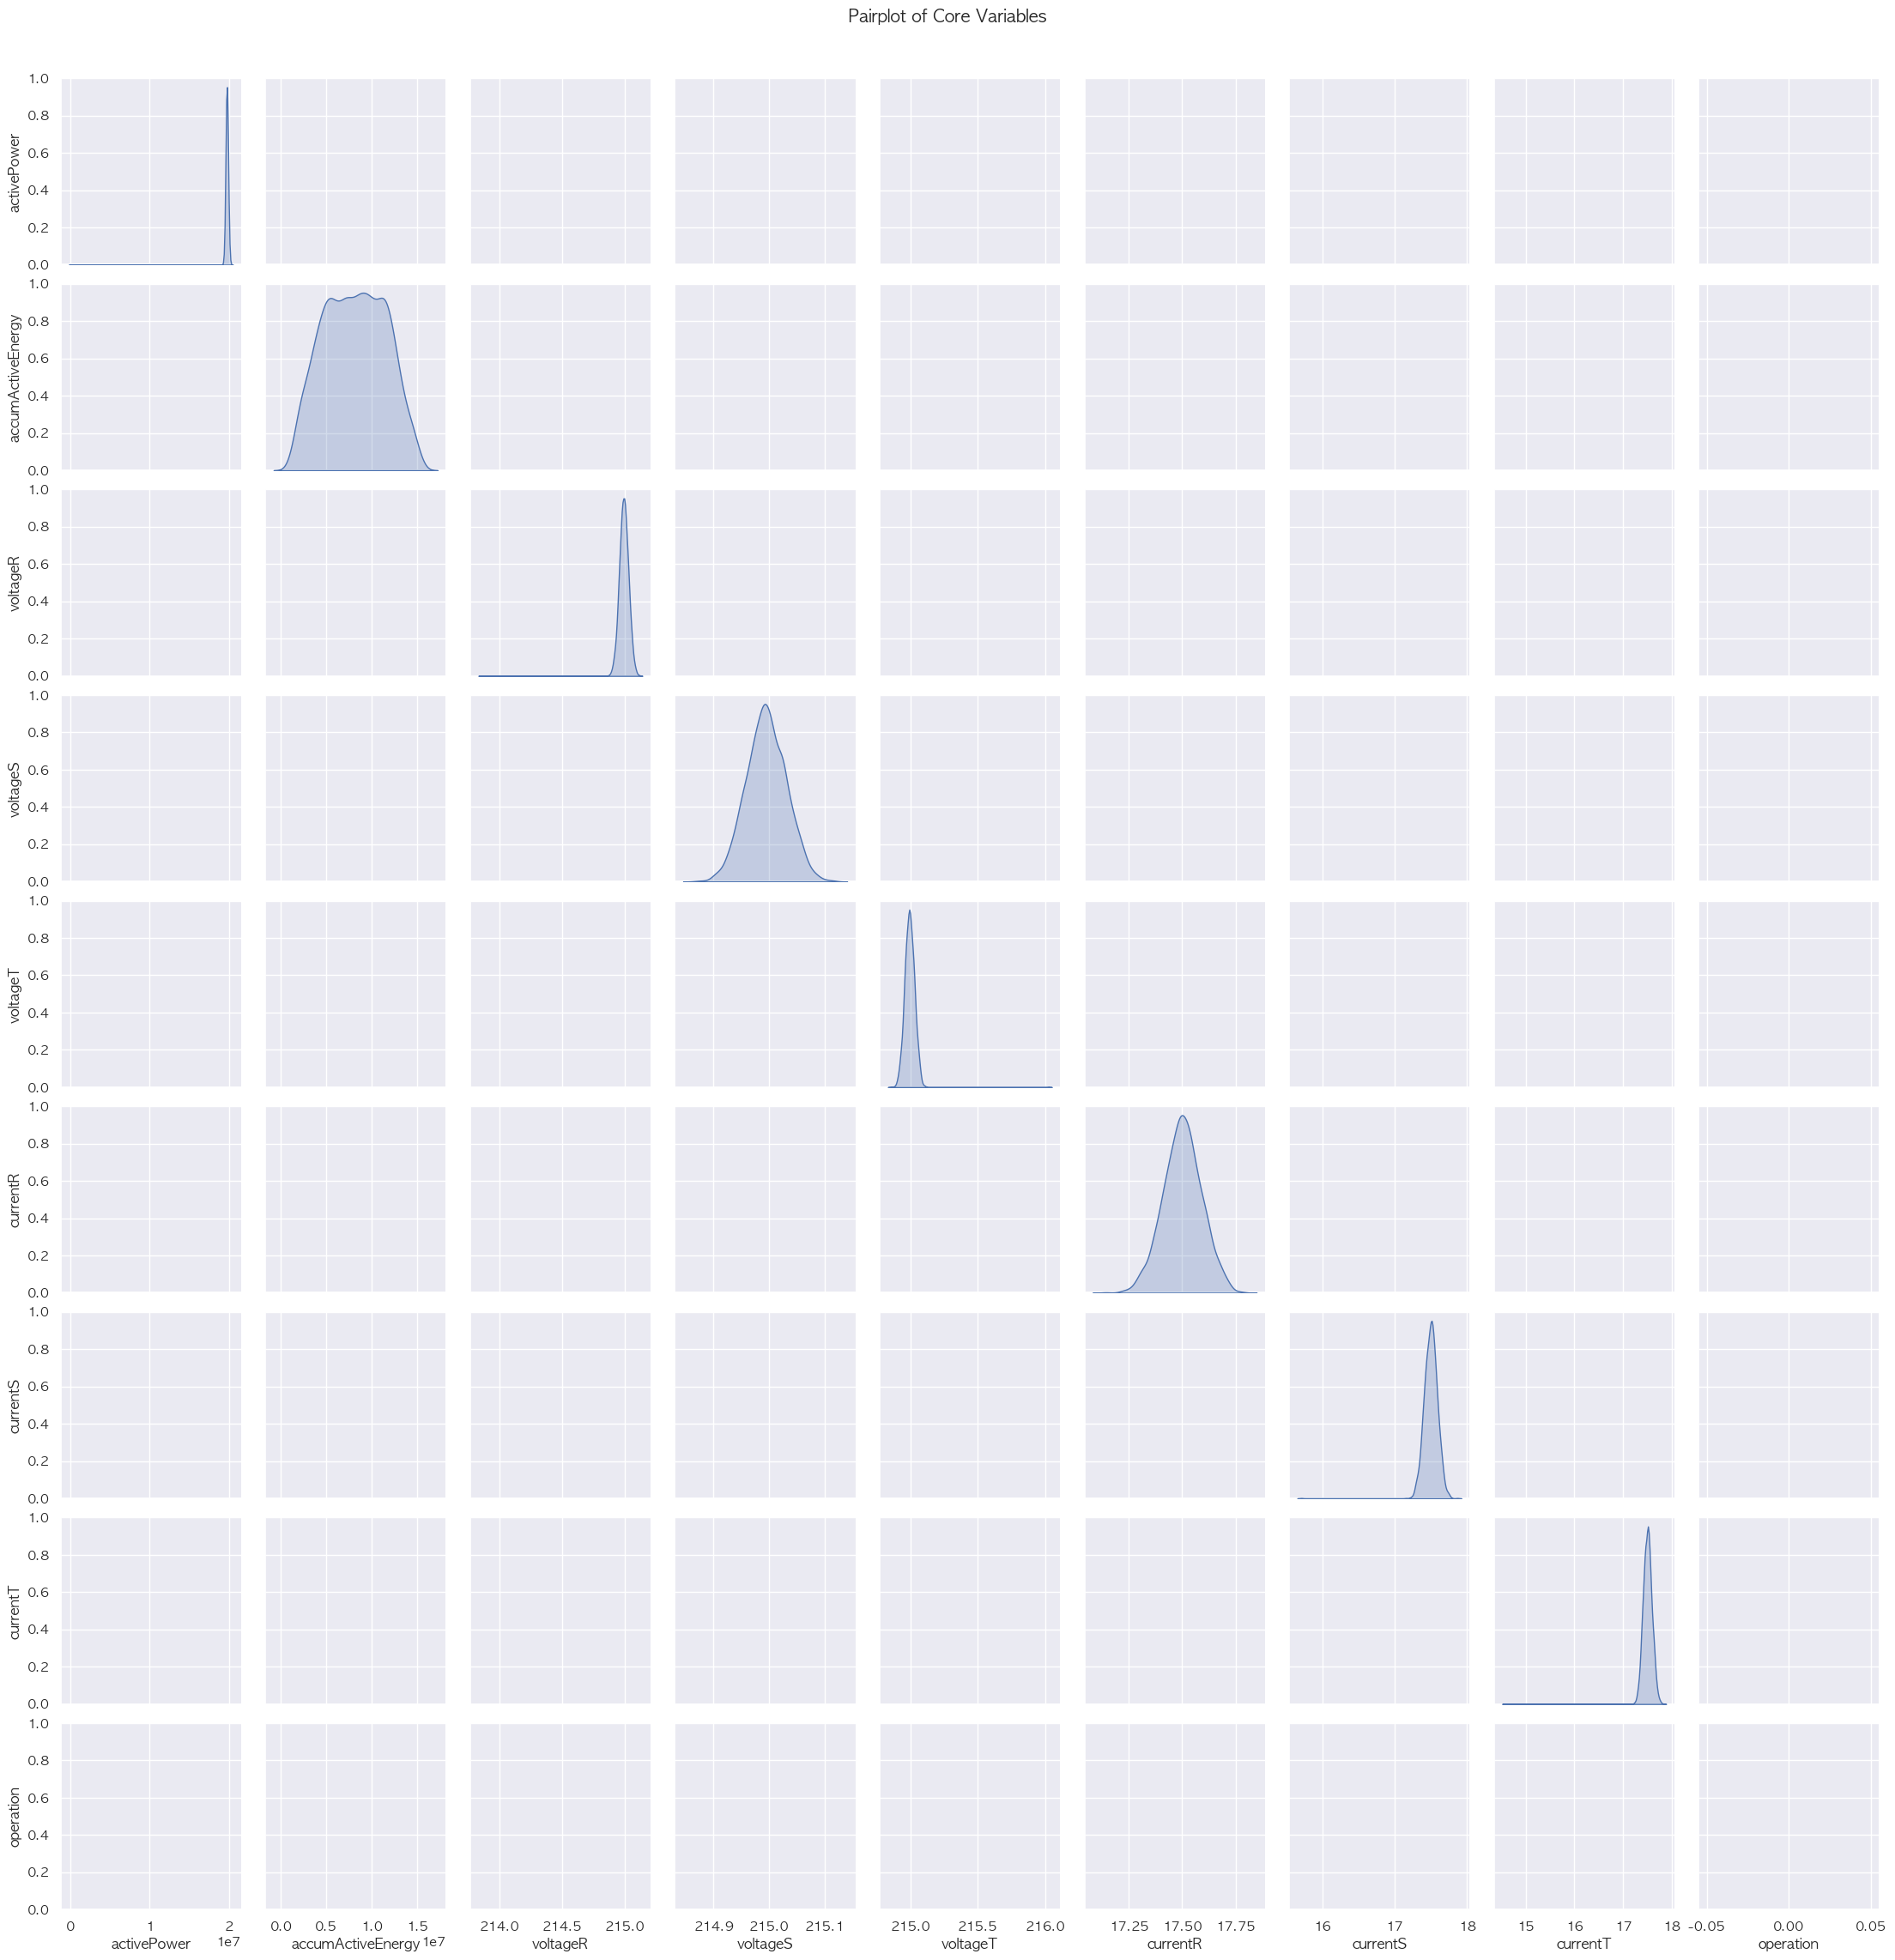

In [45]:
vars_to_plot = ["activePower", "accumActiveEnergy", "voltageR", "voltageS", "voltageT", "currentR", "currentS", "currentT", "operation"]

sns.pairplot(main_hourly[vars_to_plot], kind="operation", diag_kind="kde", plot_kws={"alpha": 0.3, 's': 20})
plt.suptitle("Pairplot of Core Variables", y=1.02)
plt.show()

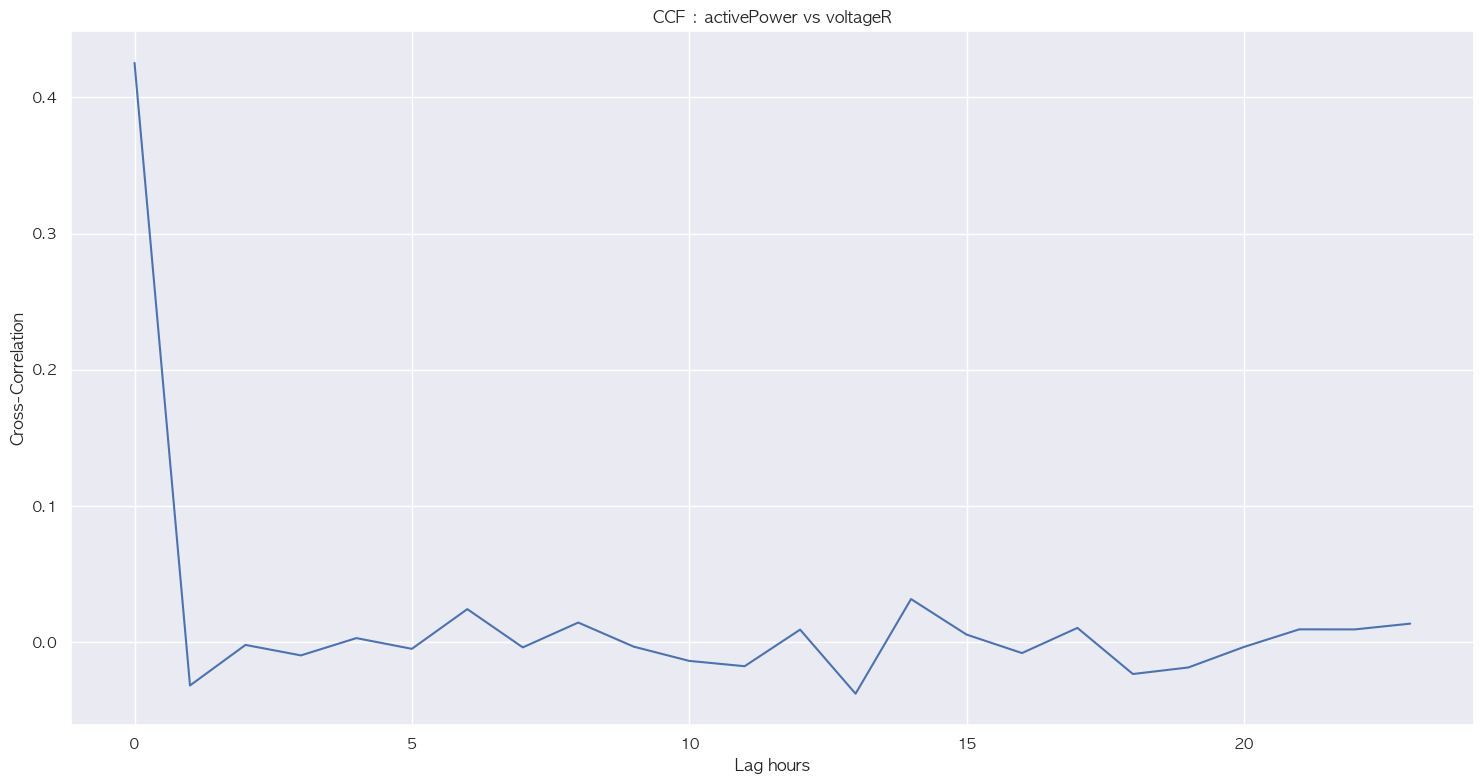

In [52]:
cc_vals = ccf(main_hourly["activePower"], main_hourly["voltageR"])[:24]

plt.figure(figsize=(15, 8))
plt.plot(range(24), cc_vals)
plt.title("CCF : activePower vs voltageR")
plt.xlabel("Lag hours")
plt.ylabel("Cross-Correlation")
plt.tight_layout()
plt.show()



In [56]:
# 인과성 Test
grangercausalitytests(main_hourly[["activePower", "accumActiveEnergy"]], maxlag=24, verbose=True)


/Users/b._.chan/Documents/DKU_DataScience/.conda/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0746  , p=0.1499  , df_denom=3597, df_num=1
ssr based chi2 test:   chi2=2.0763  , p=0.1496  , df=1
likelihood ratio test: chi2=2.0757  , p=0.1497  , df=1
parameter F test:         F=2.0746  , p=0.1499  , df_denom=3597, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0846  , p=0.3382  , df_denom=3594, df_num=2
ssr based chi2 test:   chi2=2.1722  , p=0.3375  , df=2
likelihood ratio test: chi2=2.1715  , p=0.3376  , df=2
parameter F test:         F=1.0846  , p=0.3382  , df_denom=3594, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2777  , p=0.2802  , df_denom=3591, df_num=3
ssr based chi2 test:   chi2=3.8405  , p=0.2792  , df=3
likelihood ratio test: chi2=3.8384  , p=0.2794  , df=3
parameter F test:         F=1.2777  , p=0.2802  , df_denom=3591, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0996  , p=0.

{np.int64(1): ({'ssr_ftest': (np.float64(2.0746088364217004),
    np.float64(0.14985536310487205),
    np.float64(3597.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(2.076339119020884),
    np.float64(0.14959859163164171),
    np.int64(1)),
   'lrtest': (np.float64(2.075740573593066),
    np.float64(0.14965728418732088),
    np.int64(1)),
   'params_ftest': (np.float64(2.0746088364365605),
    np.float64(0.14985536310339823),
    np.float64(3597.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(1.08457076818131),
    np.float64(0.33815746944436004),
    np.float64(3594.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(2.1721592624844375),
    np.float64(0.33753717342878037),
    np.int64(2)),
   'lrtest': (np.float64(2.1715040279377718),
    np.float64(0.337647774553618),
    np.int64(2)),
   'params_ftest': (np.float64(1.0845707681829906),
    np.float64(0.3381574694437525),
    np.float64(3594.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
 

- 모든 lag (1~24) 에 대해 p-value 가 0.05 이상

=> accumActiveEnergy 가 activePower 예측 못해준다는 것..

In [57]:
grangercausalitytests(main_hourly[["activePower", "voltageR"]], maxlag=24, verbose=True)


/Users/b._.chan/Documents/DKU_DataScience/.conda/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5157  , p=0.0337  , df_denom=3597, df_num=1
ssr based chi2 test:   chi2=4.5194  , p=0.0335  , df=1
likelihood ratio test: chi2=4.5166  , p=0.0336  , df=1
parameter F test:         F=4.5157  , p=0.0337  , df_denom=3597, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2374  , p=0.1069  , df_denom=3594, df_num=2
ssr based chi2 test:   chi2=4.4811  , p=0.1064  , df=2
likelihood ratio test: chi2=4.4783  , p=0.1065  , df=2
parameter F test:         F=2.2374  , p=0.1069  , df_denom=3594, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6282  , p=0.1806  , df_denom=3591, df_num=3
ssr based chi2 test:   chi2=4.8941  , p=0.1797  , df=3
likelihood ratio test: chi2=4.8908  , p=0.1800  , df=3
parameter F test:         F=1.6282  , p=0.1806  , df_denom=3591, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2349  , p=0.

{np.int64(1): ({'ssr_ftest': (np.float64(4.515682146857557),
    np.float64(0.03365347872598948),
    np.float64(3597.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(4.519448353819073),
    np.float64(0.03351163501074339),
    np.int64(1)),
   'lrtest': (np.float64(4.516613862884697),
    np.float64(0.03356720401283101),
    np.int64(1)),
   'params_ftest': (np.float64(4.515682146856653),
    np.float64(0.033653478726014284),
    np.float64(3597.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(2.2374403034218275),
    np.float64(0.10688000281761653),
    np.float64(3594.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(4.481106094610549),
    np.float64(0.10639964406805084),
    np.int64(2)),
   'lrtest': (np.float64(4.4783187009743415),
    np.float64(0.10654803629630438),
    np.int64(2)),
   'params_ftest': (np.float64(2.2374403034215935),
    np.float64(0.1068800028176284),
    np.float64(3594.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],

- lag (1 : 1시간 시차) 에서만 인과관계를 확인할 수 있음.

In [58]:
grangercausalitytests(main_hourly[["activePower", "currentR"]], maxlag=24, verbose=True)


/Users/b._.chan/Documents/DKU_DataScience/.conda/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0214  , p=0.8838  , df_denom=3597, df_num=1
ssr based chi2 test:   chi2=0.0214  , p=0.8838  , df=1
likelihood ratio test: chi2=0.0214  , p=0.8838  , df=1
parameter F test:         F=0.0214  , p=0.8838  , df_denom=3597, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0667  , p=0.3443  , df_denom=3594, df_num=2
ssr based chi2 test:   chi2=2.1364  , p=0.3436  , df=2
likelihood ratio test: chi2=2.1357  , p=0.3437  , df=2
parameter F test:         F=1.0667  , p=0.3443  , df_denom=3594, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7458  , p=0.5247  , df_denom=3591, df_num=3
ssr based chi2 test:   chi2=2.2417  , p=0.5238  , df=3
likelihood ratio test: chi2=2.2410  , p=0.5239  , df=3
parameter F test:         F=0.7458  , p=0.5247  , df_denom=3591, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8866  , p=0.

{np.int64(1): ({'ssr_ftest': (np.float64(0.02135034422086901),
    np.float64(0.8838367643016558),
    np.float64(3597.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(0.021368151013380163),
    np.float64(0.8837804854398124),
    np.int64(1)),
   'lrtest': (np.float64(0.021368087604059838),
    np.float64(0.8837806566540932),
    np.int64(1)),
   'params_ftest': (np.float64(0.02135034422084376),
    np.float64(0.8838367643016558),
    np.float64(3597.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(1.066694526613034),
    np.float64(0.34425312686355436),
    np.float64(3594.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(2.136357040222766),
    np.float64(0.3436338698953901),
    np.int64(2)),
   'lrtest': (np.float64(2.1357232230511727),
    np.float64(0.34374278767670896),
    np.int64(2)),
   'params_ftest': (np.float64(1.0666945266125132),
    np.float64(0.34425312686362747),
    np.float64(3594.0),
    2.0)},
   array([[0., 0., 1., 0., 

- 모든 lag 가 유의미한 인과성을 보이지 않음.

In [60]:
# 인과성 Test
grangercausalitytests(main_hourly[["activePower", "voltageT"]], maxlag=24, verbose=True)


/Users/b._.chan/Documents/DKU_DataScience/.conda/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2084  , p=0.6480  , df_denom=3597, df_num=1
ssr based chi2 test:   chi2=0.2086  , p=0.6478  , df=1
likelihood ratio test: chi2=0.2086  , p=0.6479  , df=1
parameter F test:         F=0.2084  , p=0.6480  , df_denom=3597, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3970  , p=0.6724  , df_denom=3594, df_num=2
ssr based chi2 test:   chi2=0.7951  , p=0.6720  , df=2
likelihood ratio test: chi2=0.7950  , p=0.6720  , df=2
parameter F test:         F=0.3970  , p=0.6724  , df_denom=3594, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6741  , p=0.5678  , df_denom=3591, df_num=3
ssr based chi2 test:   chi2=2.0263  , p=0.5670  , df=3
likelihood ratio test: chi2=2.0257  , p=0.5671  , df=3
parameter F test:         F=0.6741  , p=0.5678  , df_denom=3591, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1280  , p=0.

{np.int64(1): ({'ssr_ftest': (np.float64(0.20844893950851),
    np.float64(0.6480134016733274),
    np.float64(3597.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(0.20862279183503923),
    np.float64(0.6478489936078002),
    np.int64(1)),
   'lrtest': (np.float64(0.20861674715706613),
    np.float64(0.6478537502917556),
    np.int64(1)),
   'params_ftest': (np.float64(0.2084489395085682),
    np.float64(0.6480134016733274),
    np.float64(3597.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(0.39698969464230477),
    np.float64(0.6723704334999163),
    np.float64(3594.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(0.7950839794199526),
    np.float64(0.6719697262412763),
    np.int64(2)),
   'lrtest': (np.float64(0.794996168158832),
    np.float64(0.671999230143513),
    np.int64(2)),
   'params_ftest': (np.float64(0.39698969464194084),
    np.float64(0.6723704335001846),
    np.float64(3594.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
  

# Data 수집 환경 / 상황 파악

- Data 가 어떻게, 왜 모였는지 정리
- Sensor 가 언제, 어떻게 데이터를 모았는지 확인 (ex : 1분마다 / 1시간마다 측정)
- Data 에 영향을 줄 수 있는 현장 상황 체크 (ex : 공장 휴무일, 점검일 등)

In [21]:
# Index diff check
diffs = train_df.index.to_series().diff().dt.total_seconds().dropna()

print("상위 5개 빈도 높은 측정 간격(초 단위)")
print(diffs.value_counts().head())

상위 5개 빈도 높은 측정 간격(초 단위)
localtime
0.0    20995208
5.0     2592000
Name: count, dtype: int64


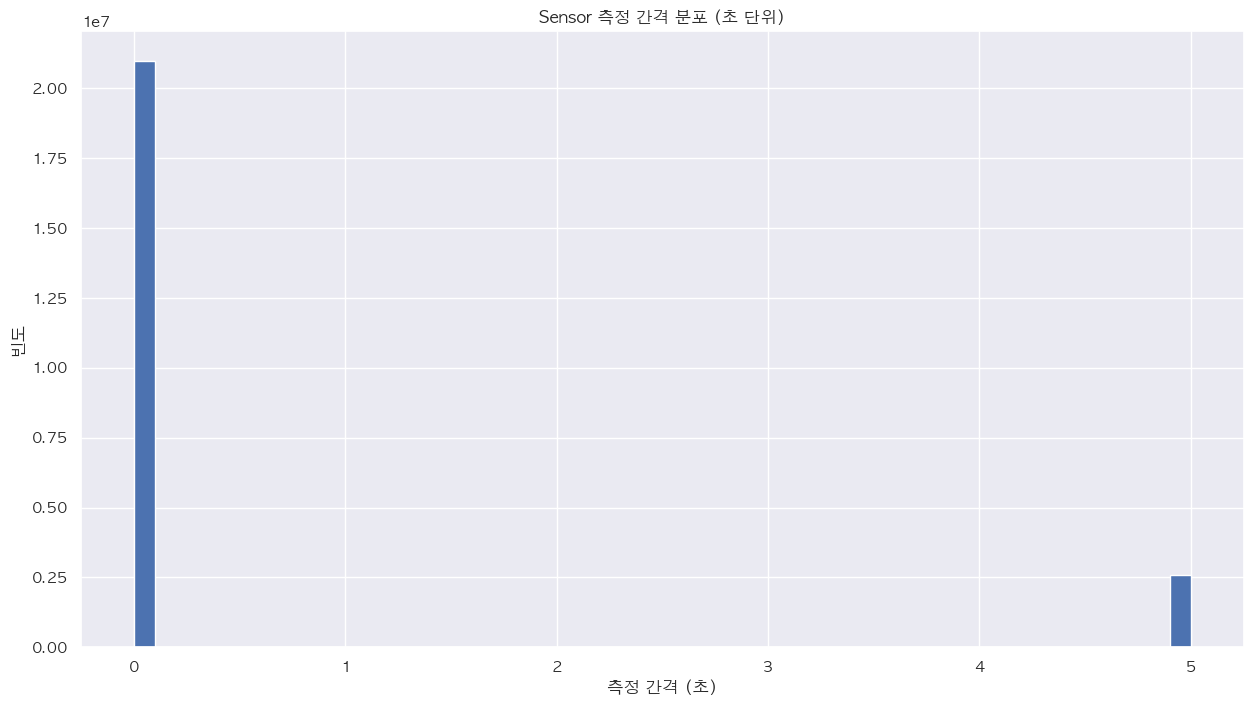

In [22]:
plt.figure(figsize=(15, 8))
diffs.hist(bins=50)
plt.title("Sensor 측정 간격 분포 (초 단위)")
plt.xlabel("측정 간격 (초)")
plt.ylabel("빈도")
plt.show()

In [23]:
# Module 별 diff check
module_diffs = (train_df.groupby("module(equipment)").apply(lambda x : x.index.to_series().diff().dt.total_seconds().dropna()
                                                            .value_counts().head(3)))

print(module_diffs)

localtime             5.0     10.0    15.0
module(equipment)                         
1(PM-3)            1270006  381421  114412
11(우측분전반1)         1269937  381385  114209
12(4호기)            1272303  381377  114216
13(3호기)            1268333  380985  114561
14(2호기)            1270286  380642  114452
15(예비건조기)          1270894  381310  114039
16(호이스트)           1269326  381458  114377
17(6호기)            1270619  380543  114768
18(우측분전반2)         1268249  381542  114523
2(L-1전등)           1270538  380873  114356
3(분쇄기(2))          1270959  381223  114136
4(분쇄기(1))          1269053  380935  114586
5(좌측분전반)           1269120  381342  114244


/var/folders/t6/dngzdyds4h36v9fcy0qzhlj40000gn/T/ipykernel_84198/3305488381.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  module_diffs = (train_df.groupby("module(equipment)").apply(lambda x : x.index.to_series().diff().dt.total_seconds().dropna()


In [24]:
# 5초 주기 외 간격만 필터링
irregular = diffs[~diffs.isin([0, 5])]

# 상위 확인
print("5초 외 간격별 빈도")
print(irregular.value_counts().head())

for interval in [10, 15]:
    times = diffs[diffs == interval].index[:5]
    print(times)

5초 외 간격별 빈도
Series([], Name: count, dtype: int64)
DatetimeIndex([], dtype='datetime64[ns]', name='localtime', freq=None)
DatetimeIndex([], dtype='datetime64[ns]', name='localtime', freq=None)


- 휴무일 관련해서는 굳이 따질 필요 없다고 판단함.

# 주요 특징 (Pattern) check

- 데이터에서 반복되는 패턴이나 규칙 확인
- 하루 / 일주일 단위로 반복되는 패턴이 있는지 확인 (Seasonality, Periodicity)
- 전체적으로 오르거나 내리는 경향 (Trend) 이 있는지 확인

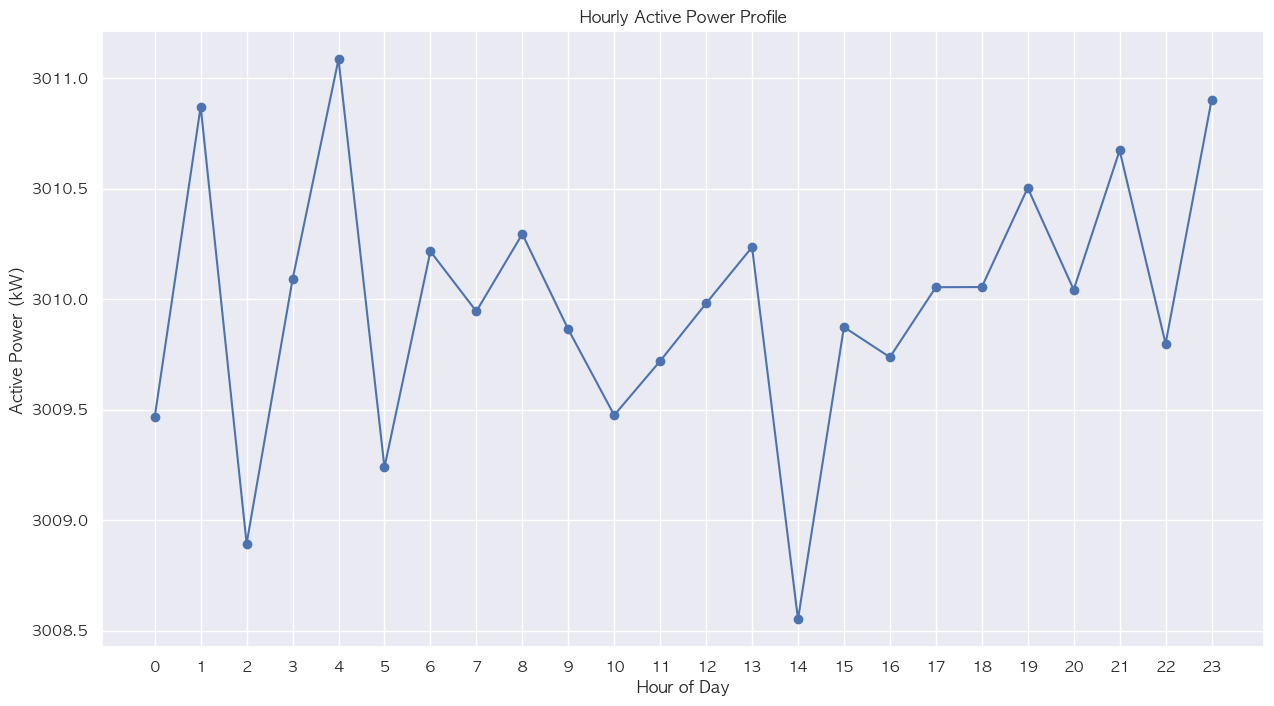

In [25]:
# 하루 단위 패턴 check
train_df["hour"] = train_df.index.hour

hourly_profile = train_df.groupby("hour")["activePower"].mean()

plt.figure(figsize=(15, 8))
plt.plot(hourly_profile.index, hourly_profile.values, marker="o")
plt.title("Hourly Active Power Profile")
plt.xlabel("Hour of Day")
plt.ylabel("Active Power (kW)")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

- 새벽 4시에 피크 (3011 kW) 를 찍는다.
- 오후 2시에 최저 (3008.6 kW) 를 찍는다.
- 전반적으로 폭은 완만해보이나, 아침과 낮, 오후 중반에 기복 존재함.

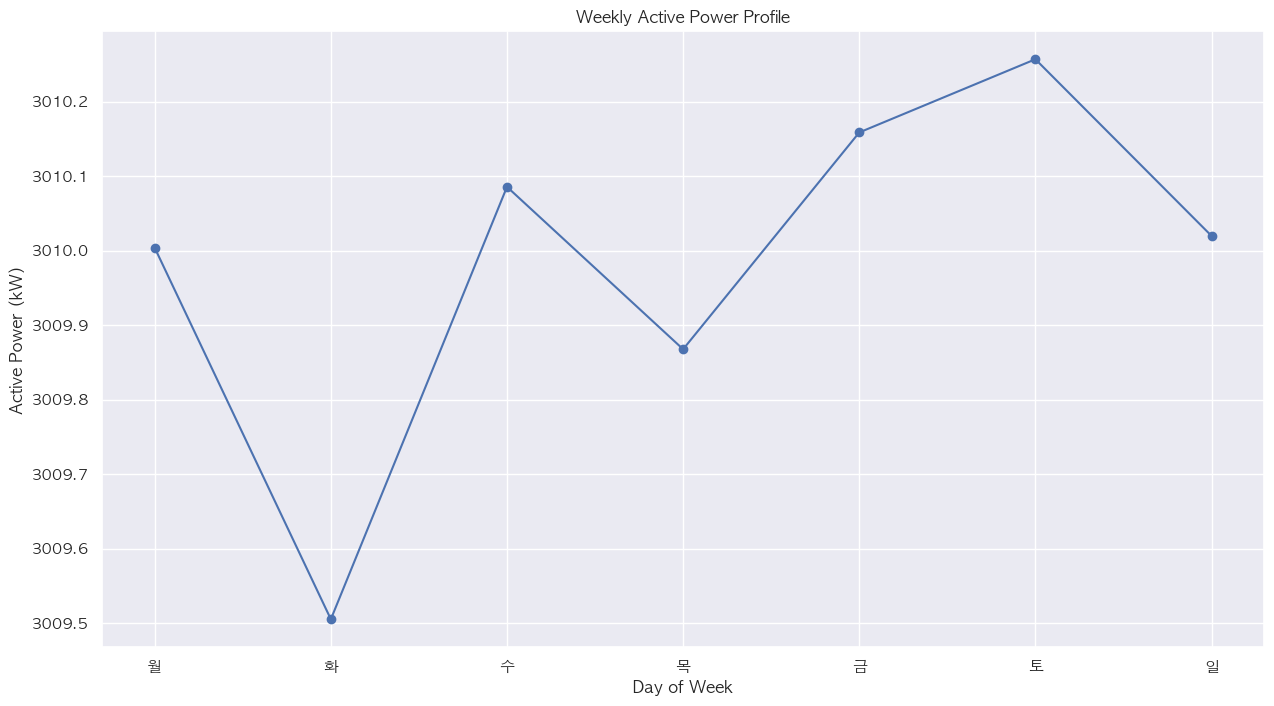

In [26]:
# 주간 패턴 확인
train_df["weekday"] = train_df.index.weekday

weekly_profile = train_df.groupby("weekday")["activePower"].mean()


fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(weekly_profile.index, weekly_profile.values, marker="o")

ax.ticklabel_format(useOffset=False) # 축 오프셋 비활성화시킴.

ax.set_title("Weekly Active Power Profile")
ax.set_xlabel("Day of Week")
ax.set_ylabel("Active Power (kW)")
ax.set_xticks(range(0, 7))
ax.set_xticklabels(["월", "화", "수", "목", "금", "토", "일"])
ax.grid(True)
plt.show()

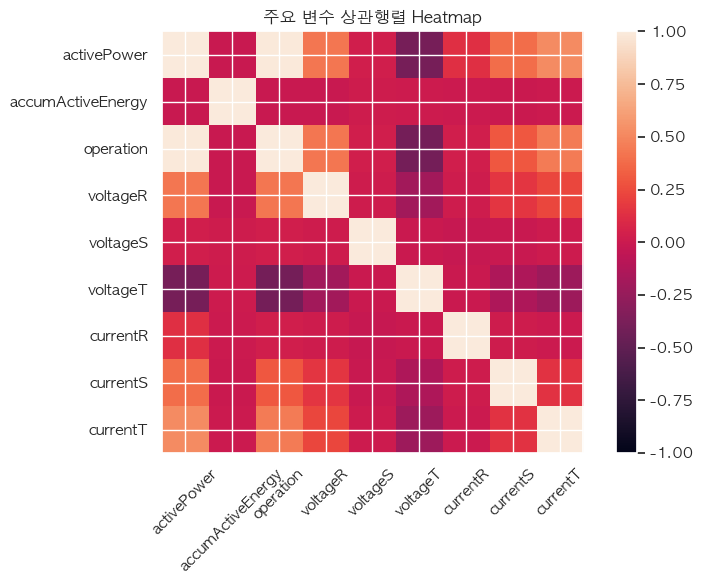

In [61]:
# 1시간 단위로 집계된 주요 변수
df_hour = train_df.resample("1h").agg({
    "activePower": "sum",
    "accumActiveEnergy": "last",
    "operation": "sum",          # 가동 비율
    "voltageR":"mean","voltageS":"mean","voltageT":"mean",
    "currentR":"mean","currentS":"mean","currentT":"mean"
})
corr = df_hour.corr()
plt.figure(figsize=(8,6))
plt.imshow(corr, vmin=-1, vmax=1, interpolation='nearest')
plt.colorbar(); 
plt.xticks(range(len(corr)), corr.columns, rotation=45);
plt.yticks(range(len(corr)), corr.index);
plt.title("주요 변수 상관행렬 Heatmap");
plt.tight_layout()
plt.show()

- 화요일 소비량이 가장 낮음 (3009.5 kW)
- 토요일이 가장 높음 (3015.5 kW)
- 주중에는 비교적 낮고, 불금부터 주말까지는 높아지는 것을 확인할 수 있는데 폭이 그렇게 크지 않아 확인해봐야 함.

/Users/b._.chan/Documents/DKU_DataScience/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


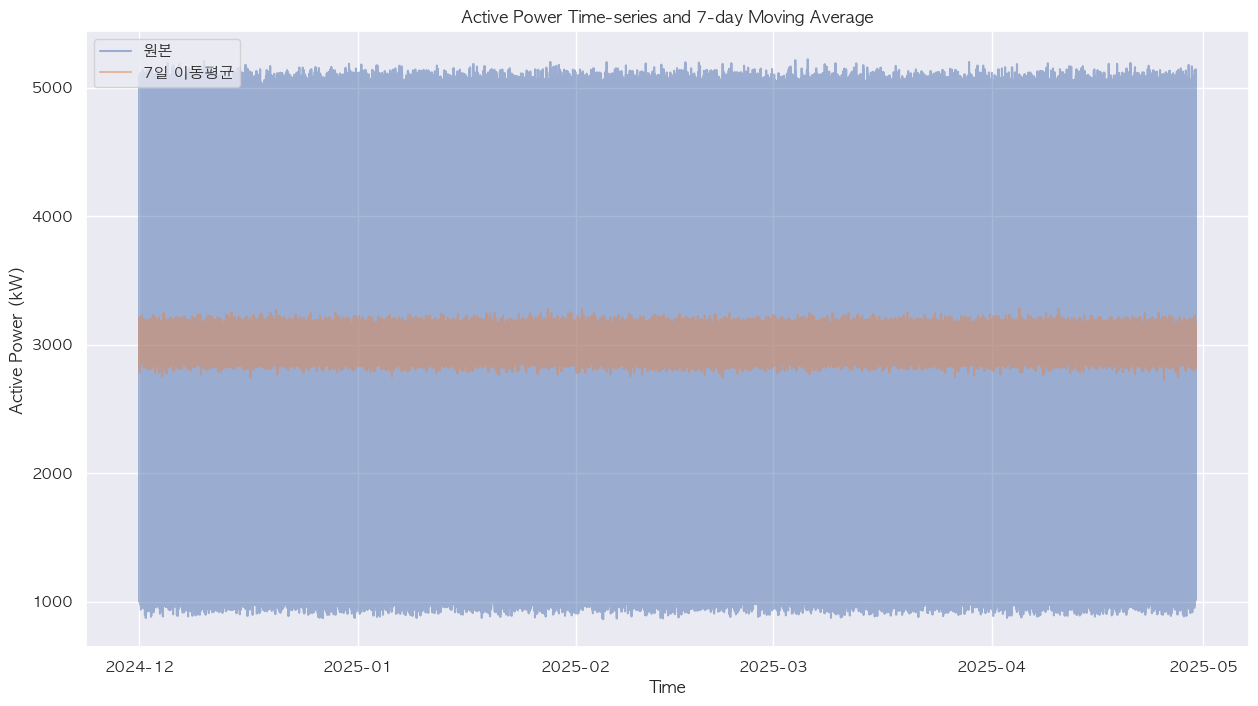

In [27]:
# Long-Term Trend check

# 24 times x 7 days = 168 times moving average
train_df["rolling_168h_mean"] = train_df["activePower"].rolling(window=168).mean()

plt.figure(figsize=(15, 8))
plt.plot(train_df["activePower"], alpha=0.5, label="원본")
plt.plot(train_df["rolling_168h_mean"], alpha=0.5, label="7일 이동평균")
plt.title("Active Power Time-series and 7-day Moving Average")
plt.xlabel("Time")
plt.ylabel("Active Power (kW)")
plt.legend()
plt.grid(True)
plt.show()



- 짧은 주기의 변동성은 커 보이는데, Trend (장기적 추세) 는 평평한 편에 속함.

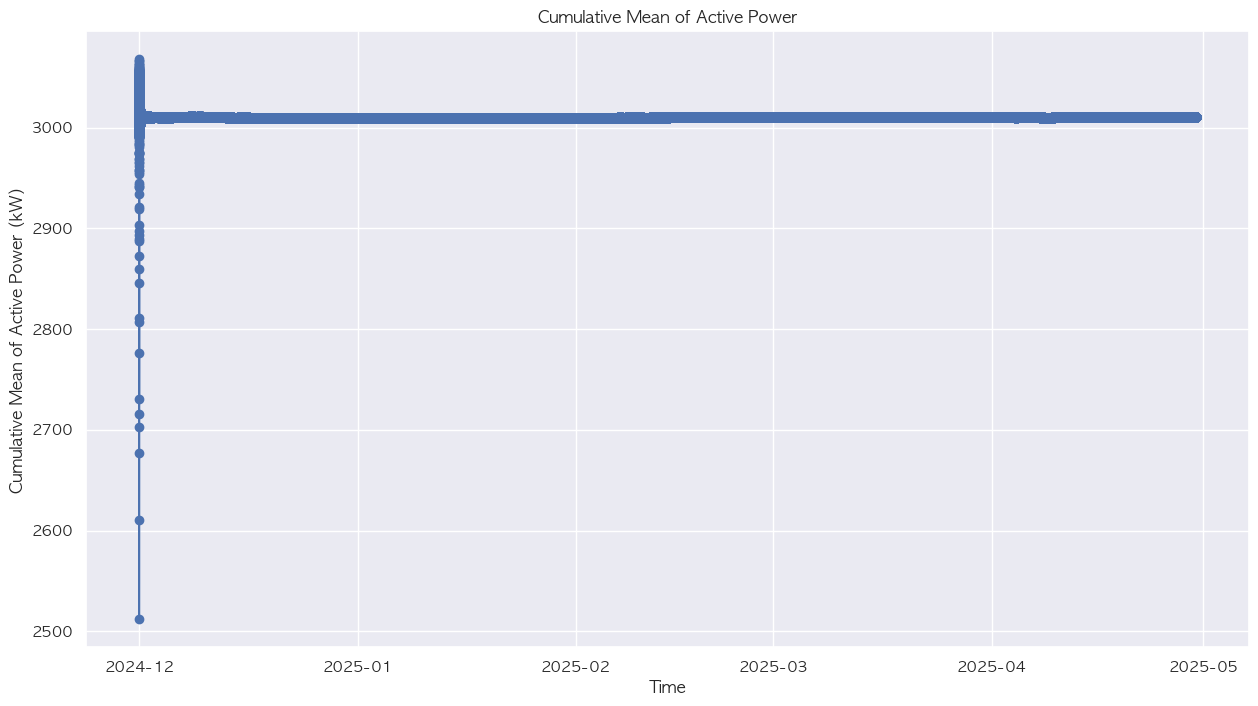

In [28]:
# 누적 평균
cum_mean = train_df["activePower"].expanding().mean()

plt.figure(figsize=(15, 8))
plt.plot(cum_mean.index, cum_mean.values, marker="o")
plt.title("Cumulative Mean of Active Power")
plt.xlabel("Time")
plt.ylabel("Cumulative Mean of Active Power (kW)")
plt.grid(True)
plt.show()



- 누적 평균은 3000 kW 전후에 거의 평평하게 수렴함.
- 평균 3000 kW 부근 중심으로 Stationary 하게 되어 있다고 판단할 수 있음.

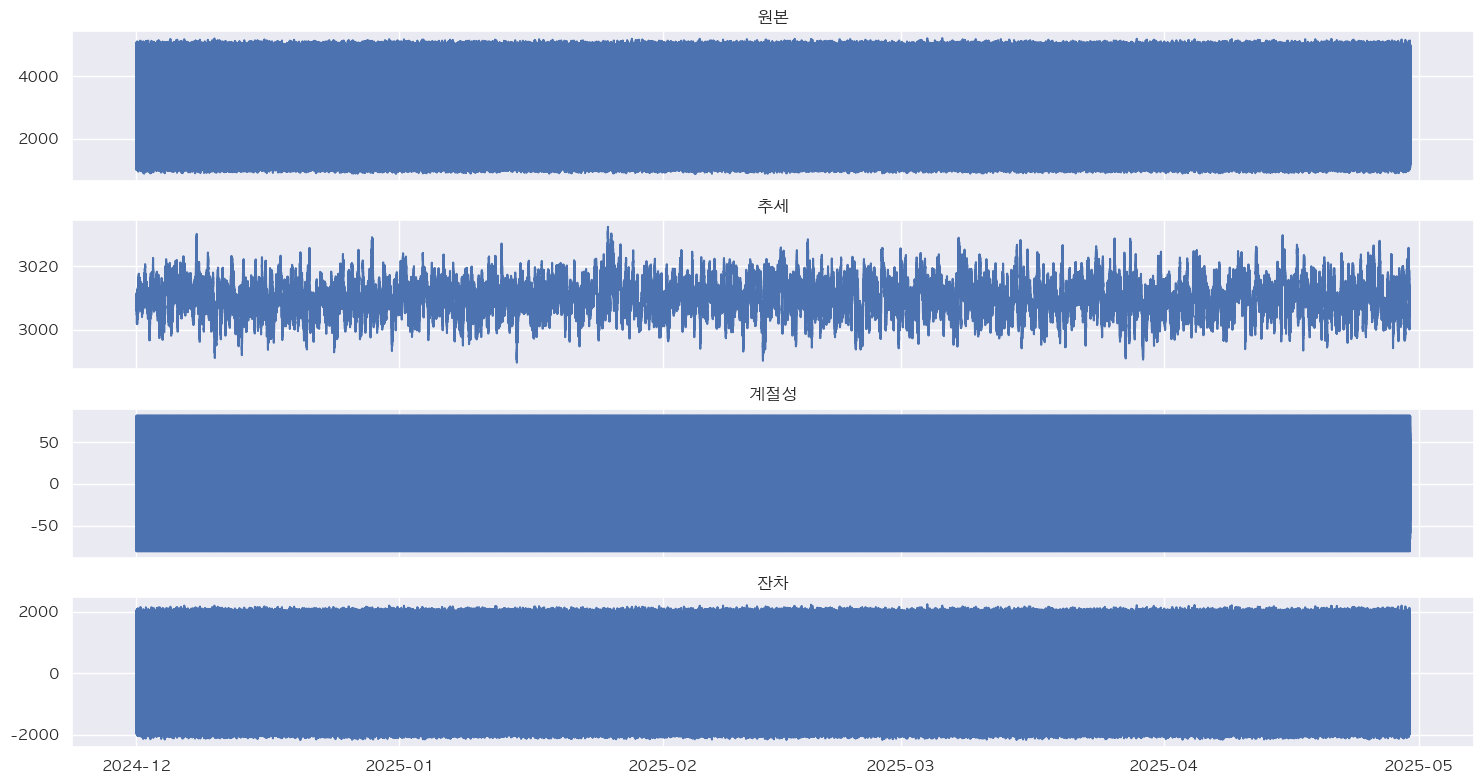

In [29]:
period_5s = int(24 * 3600 / 5) 

decomp_5s = seasonal_decompose(train_df["activePower"], model="additive", period=period_5s)

fig, axes = plt.subplots(4, 1, figsize=(15, 8), sharex=True)
titles = ["원본", "추세", "계절성", "잔차"]
series = [train_df["activePower"], decomp_5s.trend, decomp_5s.seasonal, decomp_5s.resid]
for ax, s, t, in zip(axes, series, titles):
    ax.plot(s)
    ax.set_title(t)
plt.tight_layout()
plt.show()
    


< 5초 단위 분해 >
- trend : 원본과 거의 같은 변동성 (3000 kW 대) :
- seasonal, Residual, 원본은 보이지 않음.

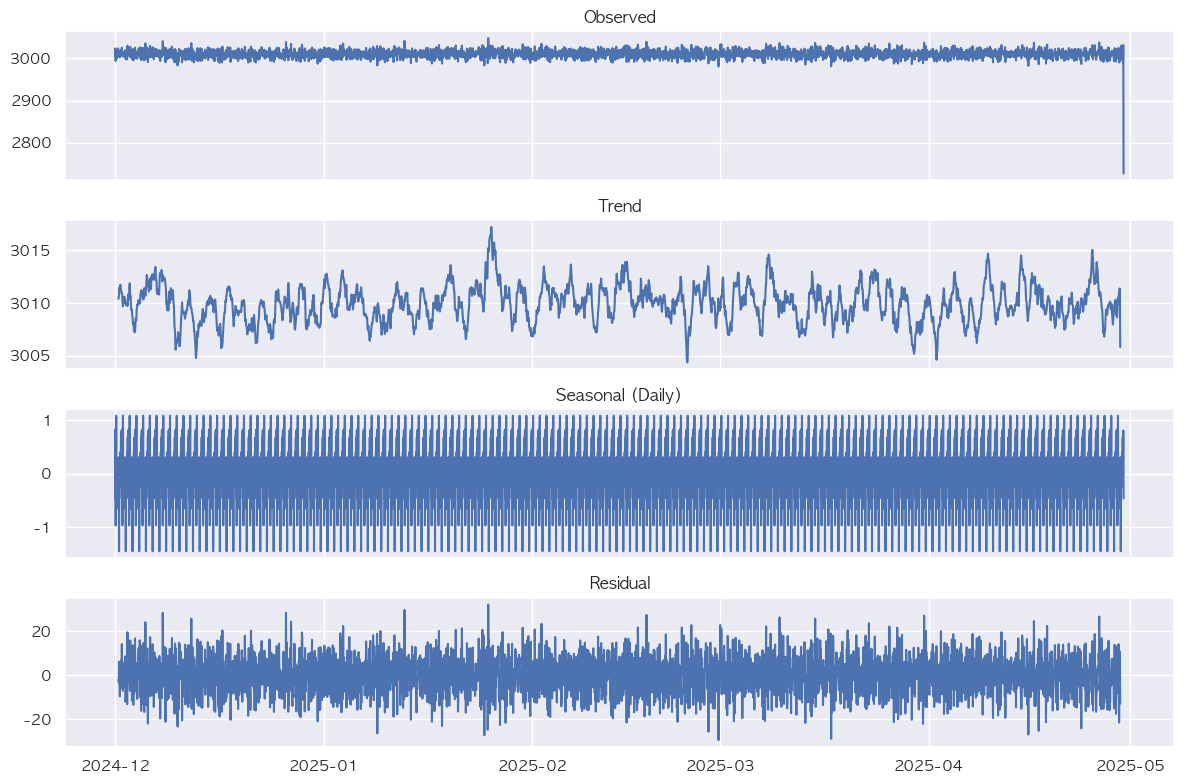

In [30]:
hourly = train_df["activePower"].resample("1h").mean()

decomp_day = seasonal_decompose(hourly, model="additive", period=24)

decomp_week = seasonal_decompose(hourly, model="additive", period=24*7)

fig, axes = plt.subplots(4,1, figsize=(12,8), sharex=True)
for ax, s, t in zip(axes,
                    [hourly, decomp_day.trend, decomp_day.seasonal, decomp_day.resid],
                    ['Observed','Trend','Seasonal (Daily)','Residual']):
    ax.plot(s)
    ax.set_title(t)
plt.tight_layout()
plt.show()

< 1H -> Daily 분해 >
- 원본 : 매 시간 합산된 Time-series
- Trend : 완만한 등락
- Seasonal (Daily) : 시간대 별 1.2 kW 정도 반복됨.
- Residual : 불규칙한 오차 발생

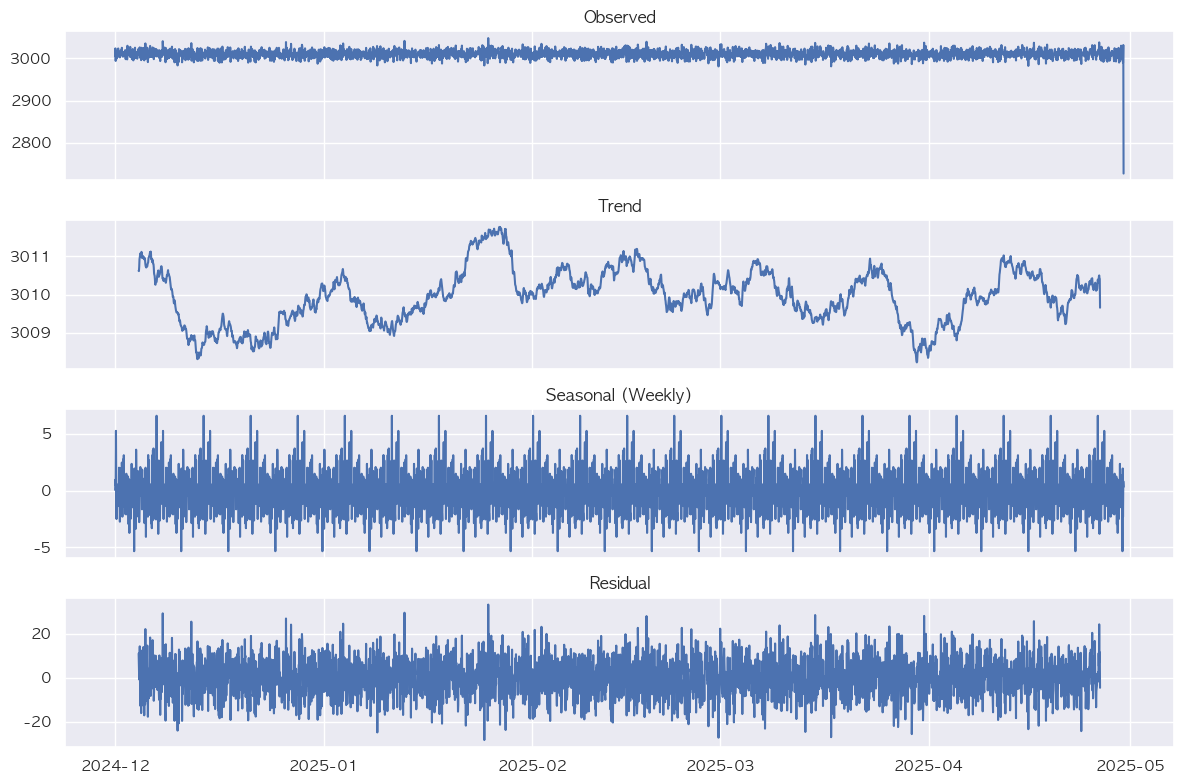

In [31]:
fig, axes = plt.subplots(4,1, figsize=(12,8), sharex=True)
for ax, s, t in zip(axes,
                    [hourly, decomp_week.trend, decomp_week.seasonal, decomp_week.resid],
                    ['Observed','Trend','Seasonal (Weekly)','Residual']):
    ax.plot(s)
    ax.set_title(t)
plt.tight_layout()
plt.show()

< 1H -> Weekly > 
- 원본 : 앞과 동일
- Trend : 거의 앞과 유사
- Seasonal (Weekly) : 168 시간 (7일) 주기, 주중 - 주말 Pattern 보임
- Residual : 25 kW 수준

1. 반복되는 패턴 / 규칙 확인
- Raw Time-series (5초 단위) 에선 하루 주기로 60kW 정도로 진동
- 1시간 집계 Time-series 에선 하루 주기로 1.2 kW 정도 규칙적 변동
-> 같은 시간대가 반복될 때마다 유사한 소비량 패턴 보임

2. 하루, 일주일 단위 계절성
- Daily Seasonality (24h)
    - 새벽 4시경 peek 찍음. -> 오후 14시 가장 적은 형태로 소비 사이클이 분해된 seasonal_daily 에서 보임.
- Weekly Seasonality (168h, 7 days)
    - 화요일 최저 -> 토요일 최고 패턴이 seasonal_weekly 성분으로 분리돼서 주중 - 주말 간 차이 보임.
-> 일간성, 주간성 다 반영할 가치 있어보임.

3. 전체적 Trend (추세)
- 7일 및 분해된 trend 성분 모두에서 평평하게 나타남.
- 뚜렷한 추세 변화는 나타나지 않음.
- stationary time-series 특성 보임.

# 데이터가 예측에 적합한지 확인

- 데이터가 너무 불규칙하거나, 한쪽으로만 쏠려 있지 않은지 확인
- 값이 한쪽에 몰려있거나, 시간에 따라 평균이 크게 바뀌면 예측 어려울 수 있음.
- 필요하면 Log 변환, 차분 등 간단한 변환 시도하여야 함.

## 분포 및 편향 확인

<Axes: >

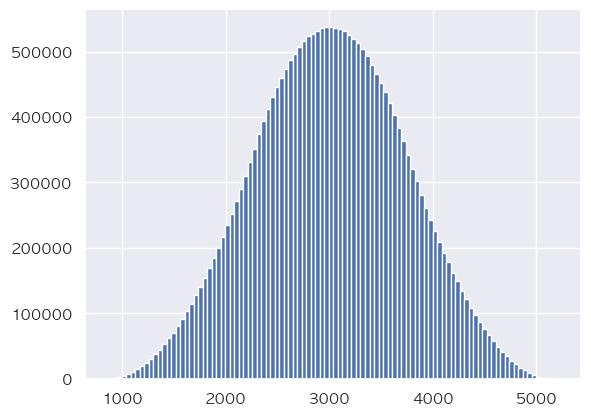

In [32]:
train_df["activePower"].hist(bins=100)

- 아까 봤다시피, 거의 완벽한 normal distribution 보임

In [33]:
skew = train_df["activePower"].skew()
kurt = train_df["activePower"].kurt()
print(f"Skewness: {skew}, Kurtosis: {kurt}")

Skewness: 0.0015901624290799497, Kurtosis: -0.399077580252154


skewness 가 그렇게 크지 않고, kurtosis 도 그렇게 크지 않아 예측에 적합함.

## stationarity check

In [34]:
hourly_pow = train_df["activePower"].resample("1h").sum().dropna()

# ADF 검정

adf_stat, adf_p, *_ = adfuller(hourly_pow)
print(f"ADF Statistic: {adf_stat:.3f}, p-value {adf_p:.3f}")

# KPSS 검정
kpss_stat, kpss_p, *_ = kpss(hourly_pow, regression="c")
print(f"KPSS Statistic: {kpss_stat:.3f}, p-value: {kpss_p:.3f}")


ADF Statistic: -25.540, p-value 0.000
KPSS Statistic: 0.187, p-value: 0.100


/var/folders/t6/dngzdyds4h36v9fcy0qzhlj40000gn/T/ipykernel_84198/1050527986.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(hourly_pow, regression="c")


- Time-series model 의 기본 가정 중 하나는 mean, 분산이 시간에 따라 일정하다는 것. (정상성)
- ADF 검정으로 unit root 확인
- p-value < 0.05 면 귀무가설을 기각하고 정상성을 확인할 수 있음.

-> ADF Statistic : -25.540, p-value ~ 0.000
-> KPASS Statistic : 0.187, p-value ~ 0.100

=> 시계열이 정상 데이터고, 추세 정상성도 확보하였음.

=> 로그, 차분 변환 불필요,, 원본 시계열 그대로 가도 됨.

## Outlier 탐지

In [35]:
Q1, Q3 = train_df["activePower"].quantile([0.25, 0.75])
IQR = Q3 - Q1

mask = (train_df["activePower"] >= Q1 - 1.5 * IQR) & (train_df["activePower"] <= Q3 + 1.5 * IQR)
outliers = train_df[~mask]
print(f"Number of outliers: {len(outliers)}")




Number of outliers: 5971


- 비율이 낮고, 너무 적어서 Noise 로 다루어도 무방할 것 같음. (모델 fit 에 영향 X)

# 예측에 쓸 데이터 구간 (window) 정하기

- 몇 시간 / 일 수 데이터를 보고 미래를 예측할지 결정
- ex : 지난 24시간 데이터를 보고 다음 1시간 예측
- 여러 window size 로 실험해보고, 결과가 제일 좋은 것을 선택

In [36]:
def make_supervised(df, target_col="activePower", window=24):
    """
    df : DatatimeIndex 로 sorted 된 DataFrame
    target_col : 예측 대상 column
    window : 과거 몇 시간(or sample) 데이터를 사용할지
    returns : X (ndarray), y(ndarray), feature_names(list)
    """
    
    values = df[target_col].values
    n = len(values)
    X, y = [], [],
    for t in range(window, n):
        X.append(values[t-window:t])
        y.append(values[t])
    X = np.array(X)
    y = np.array(y)
    feature_names = [f"lag_{i+1}" for i in range(window)]
    return X, y, feature_names






In [37]:
windows = [24, 48, 72, 168] # 시간 단위

results = []

for w in windows:
    X, y, feature_names = make_supervised(hourly_pow.to_frame(), window=w)
    
    tscv = TimeSeriesSplit(n_splits=5)
    maes = []
    
    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        maes.append(mean_absolute_error(y_val, y_pred))
    
    results.append({
        "window": w,
        "mae": np.mean(maes),
        "std": np.std(maes)
    })
    print(f"Window : {w:3d}, MAE : {np.mean(maes):.4f} ({np.std(maes):.4f})")

res_df = pd.DataFrame(results).set_index("window")
print(res_df)



Window :  24, MAE : 126411.9208 (9354.5719)
Window :  48, MAE : 125378.0298 (10243.5104)
Window :  72, MAE : 126439.1464 (9513.8390)
Window : 168, MAE : 125710.9081 (11060.3930)
                  mae           std
window                             
24      126411.920807   9354.571903
48      125378.029783  10243.510353
72      126439.146412   9513.839046
168     125710.908073  11060.393041


- 48h mae 가 가장 큼.

-> 지난 48 시간의 pattern 을 보고 다음 시간 소비를 예측하는 방향성으로 가면 좋을듯.

- 168h mae 도 나쁘지 않아서 Multi 로 진행해도 괜찮음.

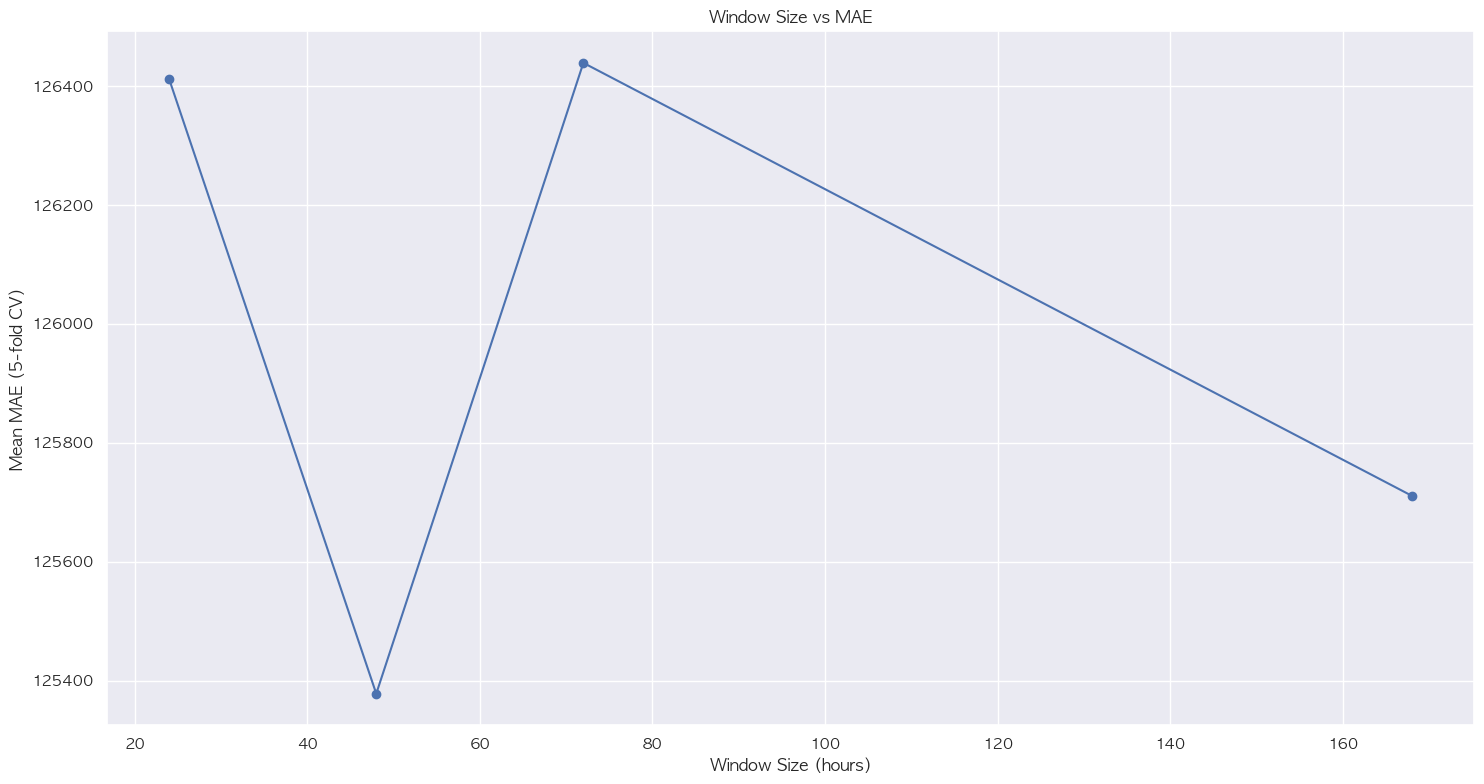

In [38]:
plt.figure(figsize=(15, 8))
plt.plot(res_df.index, res_df["mae"], marker="o")
plt.title("Window Size vs MAE")
plt.xlabel("Window Size (hours)")
plt.ylabel("Mean MAE (5-fold CV)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Multicollinearity check

In [39]:
feat = hourly_pow.to_frame()

for lag in range(1, 25):
    feat[f"lag_{lag}"] = feat["activePower"].shift(lag)
feat['rolling_24h'] = feat['activePower'].rolling(window=24).mean()
feat = feat.dropna()

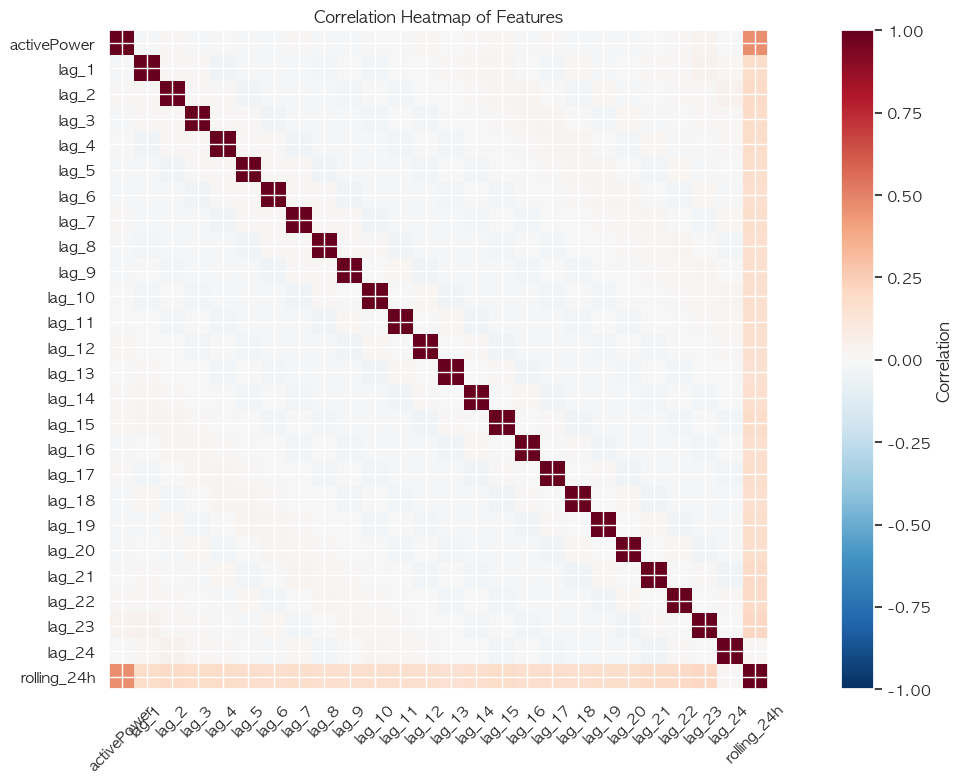

In [40]:
corr = feat.corr()

plt.figure(figsize=(15, 8))
plt.imshow(corr, vmin=-1, vmax=1, cmap="RdBu_r")
plt.colorbar(label="Correlation")
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Correlation Heatmap of Features")
plt.tight_layout()
plt.show()

